In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [2]:
#Note 1/18/23: Flux tower footprint (fluxproper) OR expanded flux area (fluxdiss)
gce_fluxdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_fluxdissolve.shp'

gce_fluxproper = 'F:/Wetlands shapefiles/GCE flux tower/sapelo_yearly_climatology-2019.shp'

flux_ga = geemap.shp_to_ee(gce_fluxproper)

In [3]:
#Pixel counts of each region:
image = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711')
x = image.reduceRegion(geometry=flux_ga, reducer=ee.Reducer.count(), scale=30)
x.getInfo()

{'QA_PIXEL': 71,
 'QA_RADSAT': 71,
 'SR_ATMOS_OPACITY': 71,
 'SR_B1': 71,
 'SR_B2': 71,
 'SR_B3': 71,
 'SR_B4': 71,
 'SR_B5': 71,
 'SR_B7': 71,
 'SR_CLOUD_QA': 71,
 'ST_ATRAN': 71,
 'ST_B6': 71,
 'ST_CDIST': 71,
 'ST_DRAD': 71,
 'ST_EMIS': 71,
 'ST_EMSD': 71,
 'ST_QA': 71,
 'ST_TRAD': 71,
 'ST_URAD': 71}

In [36]:
##FLATS

#12/08/22 - add calibrated flats to images
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))


#NOTE: above is 7-9 calibration; below is 8-9 calibration

# def addFLATSL9(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(1.51 + 12.5*(0.945*(RED-SWIR)/(RED+SWIR) - 0.055) - 41.2*(0.974* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.0005)))', {
#             'SWIR': image.select('SR_B6'),
#             'NIR': image.select('SR_B5'),
#             'RED': image.select('SR_B4'),
#             'BLUE': image.select('SR_B2')
#         })
    
#     return image.addBands(flats.rename('flats'))

# def addFLATS(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
#             'SWIR': image.select('SR_B6'),
#             'RED': image.select('SR_B4'),
#             'GREEN': image.select('SR_B3')
#         })
    
#     return image.addBands(flats.rename('flats'))

# def addFLATSL5(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
#             'SWIR': image.select('SR_B5'),
#             'RED': image.select('SR_B3'),
#             'GREEN': image.select('SR_B2')
#         })
    
#     return image.addBands(flats.rename('flats'))

#NDWI
def addndwi(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

def addndwiL5(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

#PHENO
def addpheno(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addphenoL5(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(pheno.rename('pheno'))

#NIRv
def addnirv(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(nirv.rename('nirv'))

def addnirvL5(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(nirv.rename('nirv'))

#NDVI
def addndvi(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addndviL5(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

#EVI
def addeviL5(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(evi.rename('evi'))

def addevi(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(evi.rename('evi'))

#12/01/22
#VARI
def addvariL5(image):
    vari = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED-BLUE)', {
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(vari.rename('vari'))

def addvari(image):
    vari = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED-BLUE)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(vari.rename('vari'))


#GLI
def addgliL5(image):
    gli = ee.Image(0).expression(
        '((GREEN-RED) + (GREEN-BLUE))/(2*GREEN+RED+BLUE)', {
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(gli.rename('gli'))

def addgli(image):
    gli = ee.Image(0).expression(
        '((GREEN-RED) + (GREEN-BLUE))/(2*GREEN+RED+BLUE)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(gli.rename('gli'))

In [37]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [38]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga) \
    .map(maskL5sr).map(addFLATSL8).map(addndwi).map(addpheno).map(addevi).map(addvari).map(addndvi)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL7).map(addndwiL5).map(addphenoL5).map(addeviL5).map(addvariL5).map(addndviL5) #No calibration

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL5).map(addndwiL5).map(addphenoL5).map(addeviL5).map(addvariL5).map(addndviL5)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL9).map(addndwi).map(addpheno).map(addevi).map(addvari).map(addndvi)

In [39]:
#Flux point

point_flux = ee.Geometry.Point([-81.283458, 31.444218])

flatsl5_values = l5_col.select('flats').map(lambda image: image.sample(point_flux, 1))
flatsl7_values = l7_col.select('flats').map(lambda image: image.sample(point_flux, 1))
flatsl8_values = l8_col.select('flats').map(lambda image: image.sample(point_flux, 1))
flatsl9_values = l9_col.select('flats').map(lambda image: image.sample(point_flux, 1))


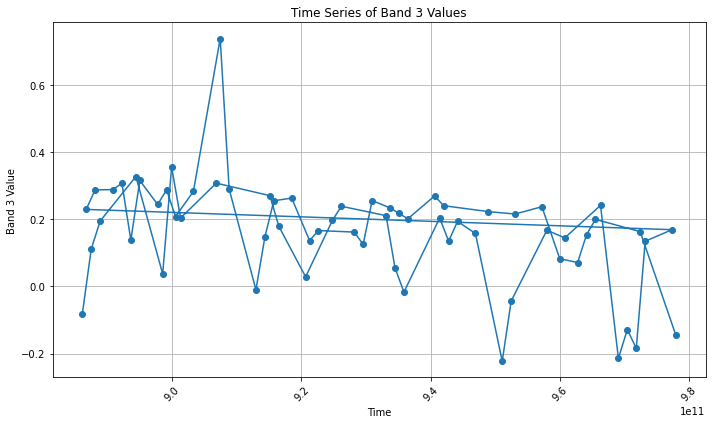

In [43]:
##SOMETHING IS VERY WRONG

# Initialize lists to store values and dates
values_list = []
dates_list = []

# Convert the collection to a list of images
image_list = l5_col.toList(l5_col.size())

# Iterate over the image list and extract values and dates
for i in range(l5_col.size().getInfo()):
    image = ee.Image(image_list.get(i))
    value = image.reduceRegion(ee.Reducer.first(), point_flux).get('ndvi')
    date = image.get('system:time_start')
    if value.getInfo() is not None:
        values_list.append(value.getInfo())
        dates_list.append(date.getInfo())


# Plot the time series using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(dates_list, values_list, marker='o')
plt.title('Time Series of Band 3 Values')
plt.xlabel('Time')
plt.ylabel('Band 3 Value')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()





In [40]:
# Function to extract NDVI and flats values at the point
collection = l5_col

def extract_values(image):
    value_ndvi = image.reduceRegion(ee.Reducer.first(), point_flux).get('ndvi')
    value_flats = image.reduceRegion(ee.Reducer.first(), point_flux).get('flats')
    return image.set('ndvi_value', value_ndvi).set('flats_value', value_flats)

# Apply the function to the collection with added bands
collection_with_values = collection.map(extract_values)


ValueError: x and y must have same first dimension, but have shapes (106,) and (45,)

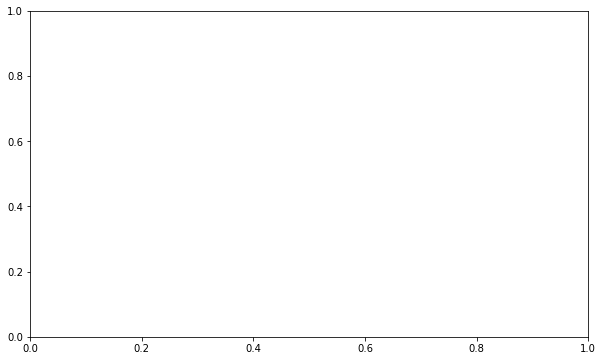

In [42]:
# Extract NDVI and flats values and dates
ndvi_values = collection_with_values.aggregate_array('ndvi_value')
flats_values = collection_with_values.aggregate_array('flats_value')
dates = collection_with_values.aggregate_array('system:time_start')

# Convert the extracted values and dates to lists
ndvi_values_list = ndvi_values.getInfo()
flats_values_list = flats_values.getInfo()
dates_list = dates.getInfo()

# Create a list to store color-coded values
color_coded_values = ['blue' if value < 0.2 else 'red' for value in flats_values_list]

# Plot the time series using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(dates_list, values_list, marker='o')
plt.title('Time Series of Band 3 Values')
plt.xlabel('Time')
plt.ylabel('Band 3 Value')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()
